In [1]:
from pyzotero import zotero
import os
import sys
from dotenv import load_dotenv
load_dotenv()
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from code_utils.zotero import get_data_from_zotero
from code_utils.glutton import get_doi_glutton
from code_utils.utils import get_doi_cleaned,aplatir
from code_utils.pickle import load_cache,write_cache
from code_utils.enriching_data_OpenAlex import get_countries_concepts_sdg,get_open_alex_data,get_open_alex_data_not_in_references

In [2]:
cached_openalex_data_ipbes = {}
cached_openalex_data_not_ipbes = {}

In [3]:
try:
    cached_openalex_data_ipbes = load_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_ipbes.pkl')
    cached_openalex_data_not_ipbes = load_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_not_ipbes.pkl')
except:
    write_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_ipbes.pkl')
    write_cache(cached_openalex_data_not_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_not_ipbes.pkl')

6607 data in cached openalex data


Read IPBES references in zotero files

In [4]:
ZOTERO_KEY = os.getenv('ZOTERO_KEY')
IPBES_ZOTERO_ID = '2333077'
COLLECTION_IDS = ['8DQ8YFJI','JR5LKU4U','LBFNF62B','7IMYH9U3','DRZLUY9K','KTPTCAVF','UWNSUNXQ','BJGWRJAK','JT8FJXP6']
CHAPTER_IDS=['1','2.1','2.2','2.3','3','4','5','6','glossary']
ALL_COLLECTIONS={}

In [5]:
ALL_COLLECTIONS=get_data_from_zotero(ZOTERO_KEY,IPBES_ZOTERO_ID,COLLECTION_IDS,CHAPTER_IDS,ALL_COLLECTIONS)

In [6]:
df_ipbes_chap={}
for i in range(len(COLLECTION_IDS)):
    df_ipbes_chap[CHAPTER_IDS[i]]=pd.DataFrame(list(pd.DataFrame(ALL_COLLECTIONS[f'collection_chapter_{CHAPTER_IDS[i]}']).data))[['DOI','title','date','creators','tags']]
    df_ipbes_chap[CHAPTER_IDS[i]]['chap']=f'chap_{CHAPTER_IDS[i]}'
    print(f'{len(df_ipbes_chap[CHAPTER_IDS[i]][~pd.isna(df_ipbes_chap[CHAPTER_IDS[i]].DOI)])/len(df_ipbes_chap[CHAPTER_IDS[i]])*100} % doi available for chapter {CHAPTER_IDS[i]}')

63.2258064516129 % doi available for chapter 1
71.26436781609196 % doi available for chapter 2.1
79.26829268292683 % doi available for chapter 2.2
79.60199004975125 % doi available for chapter 2.3
81.64682539682539 % doi available for chapter 3
85.9103385178408 % doi available for chapter 4
73.2587064676617 % doi available for chapter 5
81.23682361208714 % doi available for chapter 6
37.90613718411552 % doi available for chapter glossary


Clean and enrich data 

In [7]:
df_ipbes=pd.concat(list(df_ipbes_chap.values())).reset_index()
del df_ipbes['index']

In [8]:
len(df_ipbes[~pd.isna(df_ipbes.DOI)])/len(df_ipbes)*100

77.36948241093435

In [9]:
df_ipbes.loc[pd.isna(df_ipbes.DOI),'DOI']=df_ipbes.loc[pd.isna(df_ipbes.DOI),:].progress_apply(get_doi_glutton, axis=1)

  0%|          | 0/2020 [00:00<?, ?it/s]

In [10]:
len(df_ipbes[~pd.isna(df_ipbes.DOI)])/len(df_ipbes)*100

89.3009186645754

In [11]:
df_ipbes.loc[:,'DOI']=df_ipbes.loc[:,'DOI'].apply(lambda x: get_doi_cleaned(x))
df_ipbes.loc[:,'DOI']=df_ipbes.loc[:,'DOI'].apply(lambda x: None if str(x)[:4]=='http' else x)
df_ipbes['freq']=1
df_ipbes=df_ipbes.rename(columns={'DOI':'doi'})

Enriching data through OpenAlex API integration

In [12]:
df_unique_doi=df_ipbes.groupby(by=['doi'], dropna=True).agg({'chap': lambda x: list(x), 'freq': 'sum'})
df_unique_doi=df_unique_doi.reset_index()

In [13]:
#get data_OpenAlex from the API 
df_unique_doi.apply(lambda row: get_open_alex_data(cached_openalex_data_ipbes,row['doi']), axis= 1)
write_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_ipbes.pkl')

In [14]:
year_list = []
countries_list = []
concepts_list = []
sdg_list = []
topics_list = []
for i,row in df_unique_doi.iterrows():
    countries,concepts,sdg,year,topics=get_countries_concepts_sdg(cached_openalex_data_ipbes,row)

    countries_list.append(countries)
    concepts_list.append(concepts)
    sdg_list.append(sdg)
    year_list.append(year)   
    topics_list.append(topics)   

df_unique_doi['countries'] = countries_list
df_unique_doi['concepts'] = concepts_list
df_unique_doi['sdg'] = sdg_list
df_unique_doi['year'] = year_list
df_unique_doi['topics'] = topics_list

Visualization of the contribution of each countries in ipcc references

In [15]:
df_ipbes=pd.merge(df_ipbes, df_unique_doi[['doi','countries','concepts','sdg','year']], on='doi', how='left')
df_ipbes.loc[:,'countries']=df_ipbes.loc[:,'countries'].apply(lambda x: str(x).replace('nan','None').replace('[]','None').replace('[None]','None') if ((str(x)=='nan')|(str(x)=='[None]')|((str(x)=='[]'))) else x )
df_ipbes.loc[:,'countries']=df_ipbes.loc[:,'countries'].apply(lambda x: ['None'] if x=='None' else x)

In [16]:
#df_ipbes.to_json(module_path+'\\IPCC_bibliography\\AR6\\structured_data\\data_ipbes_visualization.json', orient='records')

In [17]:
data_counts = pd.Series(aplatir(list(df_ipbes['countries']))).value_counts().drop('None')

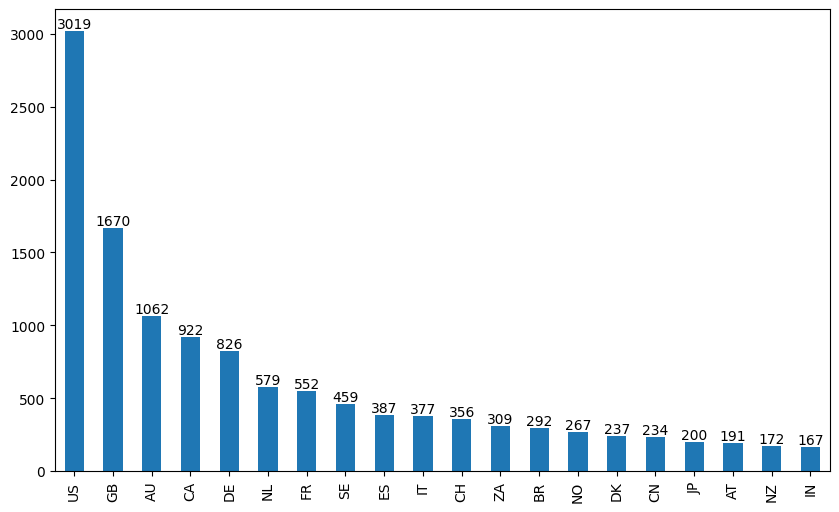

In [18]:
plt.figure(figsize=(10, 6))
data_counts[:20].plot(kind='bar')
ax = data_counts[:20].plot(kind='bar')
for i, v in enumerate(data_counts[:20]):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.show()

Find the data for constructing the learning model ( IPBES related or not )

In [19]:
df_ipbes['year'] = pd.to_numeric(df_ipbes['year'], errors='coerce')
year=df_ipbes.drop_duplicates(subset='doi')['year'].dropna().sort_values().apply(lambda x: int(x))
year_counts = pd.Series(list(year)).value_counts().to_dict()

In [20]:
dois=list(df_unique_doi.doi)

In [21]:
year_counts_not_ipbes={}
target_iterations = len(dois)

In [22]:
for year in list(year_counts.keys()):   
    cached_openalex_data_not_ipbes[year]=[]
    year_counts_not_ipbes[year]=0
    while year_counts_not_ipbes[year]<year_counts[year]:
        get_open_alex_data_not_in_references(dois,cached_openalex_data_not_ipbes,year_counts,year_counts_not_ipbes,year)
    cached_openalex_data_not_ipbes[year]=cached_openalex_data_not_ipbes[year][:year_counts[year]+1]
write_cache(cached_openalex_data_not_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_not_ipbes.pkl')

plus que 702 publications pour completer l'année 2016
plus que 607 publications pour completer l'année 2016
plus que 524 publications pour completer l'année 2016
plus que 422 publications pour completer l'année 2016
plus que 332 publications pour completer l'année 2016
plus que 236 publications pour completer l'année 2016
plus que 145 publications pour completer l'année 2016
plus que 46 publications pour completer l'année 2016
plus que 624 publications pour completer l'année 2017
plus que 540 publications pour completer l'année 2017
plus que 445 publications pour completer l'année 2017
plus que 348 publications pour completer l'année 2017
plus que 255 publications pour completer l'année 2017
plus que 159 publications pour completer l'année 2017
plus que 63 publications pour completer l'année 2017
plus que 620 publications pour completer l'année 2015
plus que 534 publications pour completer l'année 2015
plus que 430 publications pour completer l'année 2015
plus que 336 publications pour

In [64]:
df_not_ipbes=pd.DataFrame()
year_list = []
countries_list = []
concepts_list = []
sdg_list = []
topics_list = []
dois_list = []
for k in range(len(aplatir(list(cached_openalex_data_not_ipbes.values())))):
    countries,concepts,sdg,year,topics,doi=get_countries_concepts_sdg(cached_openalex_data=aplatir(list(cached_openalex_data_not_ipbes.values())),ipcc=False,i=k)

    countries_list.append(countries)
    concepts_list.append(concepts)
    sdg_list.append(sdg)
    year_list.append(year)   
    topics_list.append(topics)   
    dois_list.append(doi)   

df_not_ipbes['countries'] = countries_list
df_not_ipbes['concepts'] = concepts_list
df_not_ipbes['sdg'] = sdg_list
df_not_ipbes['year'] = year_list
df_not_ipbes['topics'] = topics_list
df_not_ipbes['doi'] = dois_list

https://doi.org/10.1201/b21520-16
https://doi.org/10.1163/2210-7975_hrd-0965-0060
https://doi.org/10.18632/oncotarget.6846
https://doi.org/10.1109/icpes.2016.7584235
https://doi.org/10.1038/nmat4549
https://doi.org/10.1016/j.jnci.2016.09.002
https://doi.org/10.7765/9781526111753.00013
https://doi.org/10.11648/j.ajim.20160406.15
https://doi.org/10.21125/iceri.2016.0602
https://doi.org/10.15728/bbr.2016.13.5.5
https://doi.org/10.1007/978-3-658-14686-3_14
https://doi.org/10.1007/978-90-368-1623-6_6
https://doi.org/10.1109/pesgm.2016.7741866
https://doi.org/10.1108/jmd-12-2015-0174
https://doi.org/10.1007/978-3-319-40845-3_32
https://doi.org/10.1007/s00592-016-0950-1
https://doi.org/10.1515/eces-2016-0038
https://doi.org/10.1242/jcs.197301
https://doi.org/10.1016/j.sna.2016.07.025
https://doi.org/10.17485/ijst/2016/v9i43/101859
https://doi.org/10.17140/oroj-2-117
https://doi.org/10.16977/cbfm.27.2_281
https://doi.org/10.1364/ao.55.006371
https://doi.org/10.3760/cma.j.issn.1008-1372.2016.06

In [65]:
df_not_ipbes

,countries,concepts,sdg,year,topics,doi
0,[],"[{'name': 'Landslide'}, {'name': 'Geology'}, {...","[{'id': '13', 'name': 'Climate action'}]",2016,[{'name': 'Landslide Hazards and Risk Assessme...,https://doi.org/10.1201/b21520-16
1,[None],"[{'name': 'Appeal'}, {'name': 'Political scien...","[{'id': '16', 'name': 'Peace, justice, and str...",2016,[{'name': 'European Union Criminal Law and Jus...,https://doi.org/10.1163/2210-7975_hrd-0965-0060
2,[CN],"[{'name': 'HBx'}, {'name': 'Gene knockdown'}, ...","[{'id': '3', 'name': 'Good health and well-bei...",2016,[{'name': 'Hepatitis B Infection and Treatment...,https://doi.org/10.18632/oncotarget.6846
3,[IN],[{'name': 'Ant colony optimization algorithms'...,"[{'id': '7', 'name': 'Affordable and clean ene...",2016,[{'name': 'Power Electronics and Conversion Sy...,https://doi.org/10.1109/icpes.2016.7584235
4,[US],"[{'name': 'Ribbon'}, {'name': 'Nanotechnology'...","[{'id': '2', 'name': 'Zero hunger'}]",2016,"[{'name': '3D Bioprinting Technology'}, {'name...",https://doi.org/10.1038/nmat4549
...,...,...,...,...,...,...
6645,[],"[{'name': 'Die (integrated circuit)'}, {'name'...","[{'id': '17', 'name': 'Partnerships for the go...",1943,[{'name': 'Battery Recycling and Rare Earth Re...,https://doi.org/10.1515/zpch-1943-0134
6646,[],"[{'name': 'State (computer science)'}, {'name'...","[{'id': '16', 'name': 'Peace, justice, and str...",1936,[{'name': 'International Criminal Law and Huma...,https://doi.org/10.2307/1135635
6647,[],"[{'name': 'Chemistry'}, {'name': 'Binary numbe...","[{'id': '2', 'name': 'Zero hunger'}]",1936,[{'name': 'Solid Acids in Protonic Conduction ...,https://doi.org/10.1039/tf9363200701
6648,[CN],"[{'name': 'Bacteroides fragilis'}, {'name': 'O...","[{'id': '3', 'name': 'Good health and well-bei...",2024,[{'name': 'Blood-Brain Barrier and Neurovascul...,https://doi.org/10.1080/15384101.2024.2309005


In [ ]:
df_not_ipbes.to_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_not_ipbes.jsonl', orient='records', lines= True)

IPBES learning model

In [ ]:
df_not_ipbes=pd.read_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_not_ipbes.jsonl', lines= True)